# Описание проекта

Мы имеем данные от нефтяной компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Мы построим модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# 1. Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
from scipy import stats as st


In [2]:
region_1 = pd.read_csv('datasets/geo_data_0.csv')
region_2 = pd.read_csv('datasets/geo_data_1.csv')
region_3 = pd.read_csv('datasets/geo_data_2.csv')

region_1.info()
region_2.info()
region_3.info()
display(region_1.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null 

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [3]:
# Проверка на дубликаты
assert region_1.duplicated().sum() == 0, 'Duplicates detected!'
assert region_2.duplicated().sum() == 0, 'Duplicates detected!'
assert region_3.duplicated().sum() == 0, 'Duplicates detected!'


## Данные по региону 1

________________________________Частотные гистограммы по региону 1________________________________


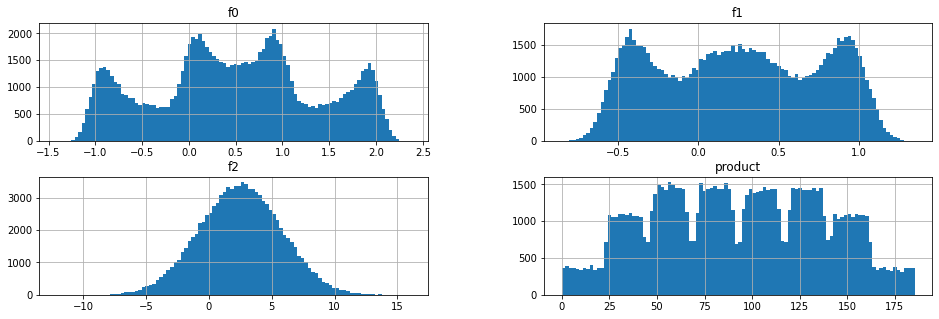

Таблица кореляций.


,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


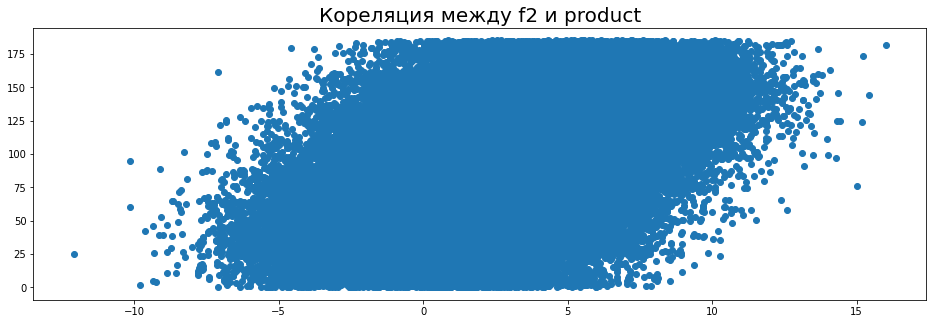

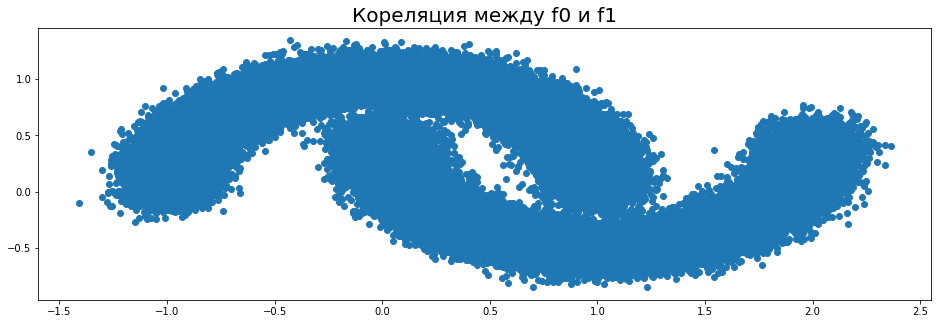

In [4]:
print(f'Частотные гистограммы по региону 1'.center(98,'_'))
region_1.hist(figsize=(16,5), bins=100)
plt.show()

print('Таблица кореляций.')
display(region_1.corr())

plt.figure(figsize=(16,5))
plt.title('Кореляция между f2 и product', fontsize=20)
plt.scatter(region_1['f2'],region_1['product'] )
plt.show()

plt.figure(figsize=(16,5))
plt.title('Кореляция между f0 и f1', fontsize=20)
plt.scatter(region_1['f0'],region_1['f1'] )
plt.show()

### Вывод

Из того что заинтересовало по этому региону на данном этапе это нелинейная кореляция между f0 и f1. Интересно как при построении модели повлияет удаление одного из показателей.
Зубья на графике продукта, говорят скроее о том, что данные предположительно округлялись при сборе.

## Данные по региону 2

________________________________Частотные гистограммы по региону 2________________________________


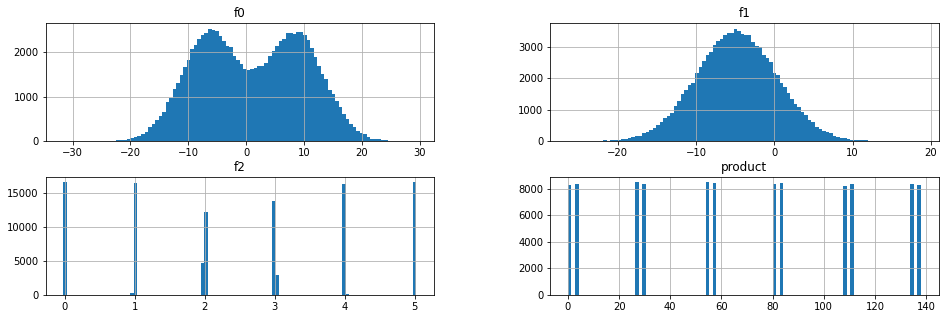

Таблица кореляций.


,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


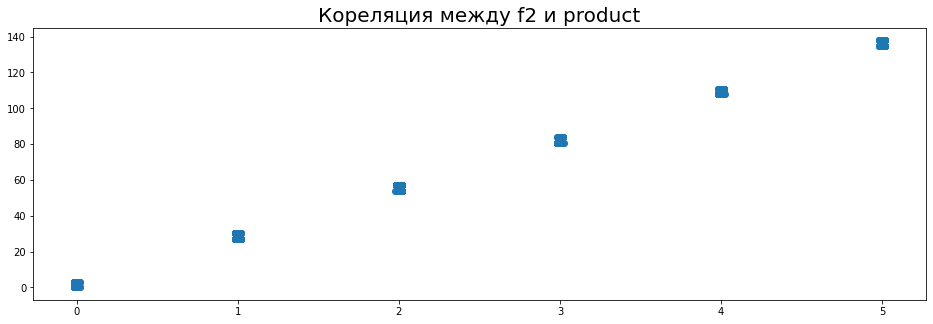

In [5]:
print(f'Частотные гистограммы по региону 2'.center(98,'_'))
region_2.hist(figsize=(16,5), bins=100)
plt.show()

print('Таблица кореляций.')
display(region_2.corr())

plt.figure(figsize=(16,5))
plt.title('Кореляция между f2 и product', fontsize=20)
plt.scatter(region_2['f2'],region_2['product'] )
plt.show()

### Вывод

По этому региону имеем почти прямую зависимость между f2 и product. Слишком большая зависимость, не является ли параметр f2 данными из будущего? Скорее всего при обучении модели мы не сможем пользоваться данными f2, иначе все это очень похоже на утечку данных. Это может привести к тому, что на обучении мы получим хороший результат а при дальнейшем использовании, модель покажет себя плохо, или вообще не сможет работать.

________________________________Частотные гистограммы по региону 3________________________________


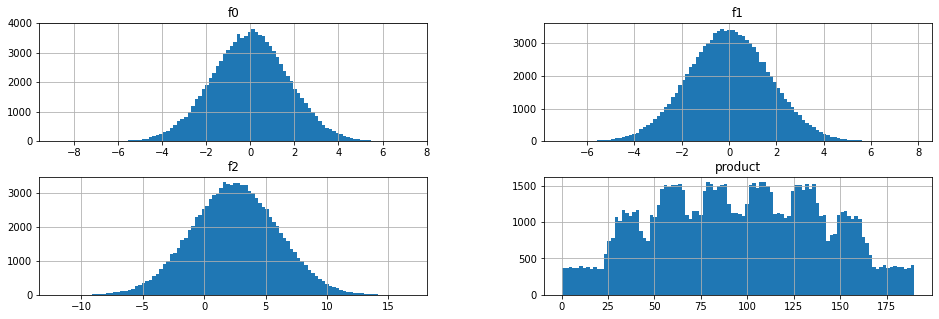

Таблица кореляций.


,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


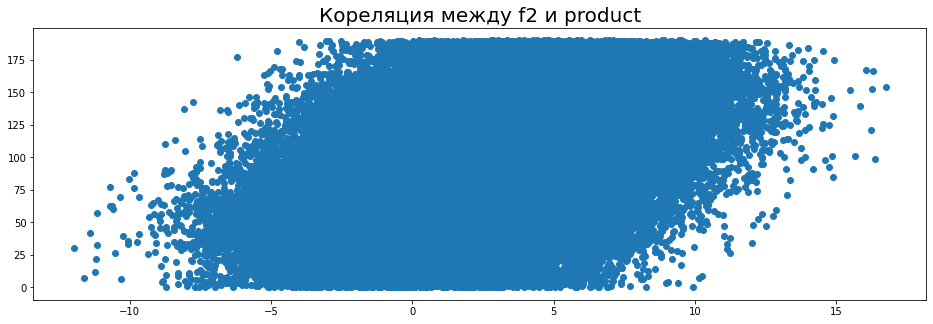

In [6]:
print(f'Частотные гистограммы по региону 3'.center(98,'_'))
region_3.hist(figsize=(16,5), bins=100)
plt.show()

print('Таблица кореляций.')
display(region_3.corr())

plt.figure(figsize=(16,5))
plt.title('Кореляция между f2 и product', fontsize=20)
plt.scatter(region_3['f2'],region_3['product'] )
plt.show()

### Вывод
По третьему региону на данном этапе нет особых вопросов к данным.

# 2. Обучение и проверка модели

In [7]:
def oil_predictions(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=12345
    )
    pipe = Pipeline([('scaler', StandardScaler()), ('linear_regression', LinearRegression())])
    pipe.fit(X_train, y_train)
    predicted = pipe.predict(X_test)
    print(f'Coefficient of determination R^2 is {pipe.score(X_test, y_test):.4f}.')
    print(f'Root mean squered error is {mean_squared_error(y_test, predicted)**0.5:.2f}.')
    print(f'Mean predicted barels is {predicted.mean():.2f}')
    print(f'Real mean barels is {y_test.mean():.2f}')
    result = pd.DataFrame(np.array([predicted, y_test]).T, columns=['predicted', 'true_data'])
    return result

print(f' Calculating model for region 1... '.center(93,'_'), '\n')
reg_1_predicted =  oil_predictions(region_1[['f0','f1','f2']],region_1['product'])

print(f' Calculating model for region 1 without f1 field... '.center(93,'_'), '\n')
reg_1_predicted =  oil_predictions(region_1[['f0','f2']],region_1['product'])

print(f' Calculating model for region 2... '.center(93,'_'), '\n')
reg_2_predicted =  oil_predictions(region_2[['f0','f1', 'f2']],region_2['product'])

print(f' Calculating model for region 3... '.center(93,'_'), '\n')
reg_3_predicted =  oil_predictions(region_3[['f0','f1','f2']],region_3['product'])

predictions = [reg_1_predicted, reg_2_predicted, reg_3_predicted]


_____________________________ Calculating model for region 1... _____________________________ 

Coefficient of determination R^2 is 0.2799.
Root mean squered error is 37.58.
Mean predicted barels is 92.59
Real mean barels is 92.08
_____________________ Calculating model for region 1 without f1 field... ____________________ 

Coefficient of determination R^2 is 0.2592.
Root mean squered error is 38.12.
Mean predicted barels is 92.64
Real mean barels is 92.08
_____________________________ Calculating model for region 2... _____________________________ 

Coefficient of determination R^2 is 0.9996.
Root mean squered error is 0.89.
Mean predicted barels is 68.73
Real mean barels is 68.72
_____________________________ Calculating model for region 3... _____________________________ 

Coefficient of determination R^2 is 0.2052.
Root mean squered error is 40.03.
Mean predicted barels is 94.97
Real mean barels is 94.88


###  Вывод

В первом регионе были два параметра с нелинейной кореляцией, но удалять из модели один из них не стоит, это немного ухудшает результат. Хотя надо отметить что поле f1 дает нам не так уж и много.

Модель по региону 2 получилась самой сильной. Но здесь сильная зависимость между f2 и products не может не настораживать, возможно это утечка данных, но построим модель исходя из того что данным заказчика можно доверять.

По третьему региону особых замечаний нет, данные выглядят вполне нормально.

# 3. Подготовка к расчёту прибыли

In [8]:
COSTS_PER_REGION = 10_000_000_000
PIONTS_FOR_RESEARCH = 500
PIONTS_FOR_DEVELOP = 200
REVENUE_FOR_1K_BAR = 450_000
COSTS_PER_PIONT = COSTS_PER_REGION / PIONTS_FOR_DEVELOP
MIN_BAR_FOR_PROFIT = COSTS_PER_PIONT / REVENUE_FOR_1K_BAR

print(f'Для окупаемости одного месторождения нужно минимум {MIN_BAR_FOR_PROFIT:.2f} тыс. барелей.')


Для окупаемости одного месторождения нужно минимум 111.11 тыс. барелей.


При этом средняя по всем точкам в регионах 1 и 3 в районе 90 тыс, а по второму региону средняя вообще около 70 тыс. барелей на месторождение. Значит у нас есть риск получить убыток, давайте оценим этот риск.

# 4. Расчёт прибыли и рисков 

In [ ]:
def calculating_profit(predicted_values):
    return predicted_values.sum() * REVENUE_FOR_1K_BAR - COSTS_PER_REGION

state = np.random.RandomState(12345)
steps = 1000
samples = 500

for n, region in enumerate(predictions):
    print(f' Region {n + 1} calculating... '.center(90, '_'))
    counter = 0
    profit = []
    for i in range(steps):
        select_500 = region.sample(n=samples, replace=True, random_state=state)
        best_200 = select_500.sort_values('predicted',ascending=False).head(200)
        profit_step = calculating_profit(best_200['true_data'])
        if profit_step < 0:
            counter += 1
        profit.append(profit_step)
    profit = pd.Series(profit)
    print(f'Средняя прибыль региона {profit.mean():,.0f} руб.')
    print(f'Вероятность убытков в регионе {n + 1} is - {counter / steps :.2f}')
    min_int, max_int = st.t.interval(alpha=0.95, df=len(profit)-1, loc=
                                   profit.mean(), scale=profit.sem())

    print(f'95%-ый доверительный интервал прибыли для региона {n + 1}:, '
          f'{min_int:,.0f} - {max_int:,.0f}')

________________________________ Region 1 calculating... _________________________________
Средняя прибыль региона 324,490,661 руб.
Вероятность убытков в регионе 1 is - 0.11
95%-ый доверительный интервал прибыли для региона 1:, 308,160,653 - 340,820,669
________________________________ Region 2 calculating... _________________________________


In [ ]:
best_mean_profit = 461_155_817
roi = best_mean_profit / COSTS_PER_REGION
print(f'ROI from best region will be - {roi:.2f}')

# Вывод

Второй регион показывает самые хорошие цифры. Средняя прогнозируемая прибыль по этому региону 461 млн. рублей, против 392 млн рублей в третьем регионе и 324 млн. во втором. И диапазон доверительного интервала более высокий у второго региона. Вероятность получить убыток во втором регионе равна одному проценту. В первом регионе вероятность убытка 11% а в третьем 7%, что не мало.

В итоге мы рекомендуем разрабатывать второй регион, который с большей вероятностью будет самым прибыльным для нас из всех трех.

-----